In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reddit-analysis-for-asa/reddit_posts_table.csv
/kaggle/input/reddit-analysis-for-asa/reddit_comments_table.csv


In [2]:
!pip install vaderSentiment #rule based feeling analysis intrument
import re #for sequence of character and string
import random #generates random numbers 
from datetime import datetime #supplies classes for manipulating dates and times

import plotly #interactive, publication--quality graphing library
import plotly.express as px #plotly high level interface
import plotly.graph_objects as go #for hovering on point-like objects
from plotly.subplots import make_subplots #constructs figures with arbitrary subplots
from plotly.offline import init_notebook_mode, iplot, plot #to generate graphs offline and save them in local machine
from wordcloud import WordCloud, STOPWORDS #visualizes frequent words in a text in different frequencies
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import seaborn as sns #visualization library based on matplotlib
import matplotlib.pyplot as plt #provides an object-oriented API for embedding plots into applications
%matplotlib inline 
#to enable inline plotting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 787.9 kB/s eta 0:00:00


In [3]:
df_post= pd.read_csv("/kaggle/input/reddit-analysis-for-asa/reddit_posts_table.csv") #load post data from the reddit database
df_comment= pd.read_csv("/kaggle/input/reddit-analysis-for-asa/reddit_comments_table.csv") #load comment data from the reddit database

In [4]:
sid_obj= SentimentIntensityAnalyzer() #python model for understanding feelings through words.

In [5]:
df_comment['asa_id'].value_counts() #count all asa in the scraped data

algofi            2674
Algogems          1984
choicecoin         656
Algomint           321
ZoneGameFi         118
shoshaofficial      27
Name: asa_id, dtype: int64

# **Reddit Analysis**

In [6]:
class reddit_analysis():
    '''
    A preliminary class that preprocesses asalytics reddit data to prepare it for 
    primary processing and further analysis
    '''
        
    def __init__(self): #this special method takes in the data, gets called automatically when any object of the reddit analysis class is created
        self.data= None


    def rename_post_columns(self, df_post):
        '''
        this function takes in the post table and generates unique names for each data
        label to solve the problem of inconsistency
        '''
        self.data= df_post
        self.data['post_body'] = self.data.title.astype(str).str.cat(self.data.post_text.astype(str), sep='-')
        self.data.drop(['title', 'post_text'], axis=1, inplace=True)
        self.data.rename(columns = {'id':'parent_id', "score": "post_upvotes",
                                  "time_created": "post_time_created"}, inplace = True)
        return self.data


    def rename_comment_columns(self, df_comment):
        '''
        this function takes in the comment table and generates unique names for each data
        label to solve the problem of inconsistency
        '''
        self.data= df_comment
        self.data.rename(columns= {"id": "comment_id", "body": "comment_body", "score": "comment_upvotes",
                                    "created_at": "comment_time_created"}, inplace= True)
        return self.data


    def strip_commentid_prefix(self, df_comment):
        '''
        this function takes in the comment table, removes non-correlating parent ids with trailing t3_ prefix. 
        '''
        self.data= df_comment
        self.data['parent_id'] = df_comment['parent_id'].str.lstrip("t3_")
        return self.data

  
    def merge_two_dfs(self, df_post, df_comment):
        '''
        this function takes in the post and comment tables, merges the two dataframes with the parent id column,
        and returns a merged dataframe.
        '''
        df = pd.merge(df_post, df_comment, on='parent_id', 
                       how='inner')
        return df


    def remove_URL(self, df, data:str):
        '''
        this function removes both http and https urls from all text related columns, and returns a dataframe with no url.
        '''
        for i in df[data]:
            df[data].replace(i, re.sub('((http|https):(\S+))', '', i), inplace= True)
        return df
    

    def special_character_removal(self, post_comment_text):
        '''
        this function takes in a text e.g post and comment body, removes all special characters, and returns a clean text.
        '''
        data= post_comment_text.split(" ")
        data_list= []
        for i, word in enumerate(data):
            text= ""
            for char in word:
                if char.isalpha():
                    text += char.lower()
            data_list.append(text)
        return " ".join(data_list)
    
    
    def access_scr(self, df, data:list):
        '''
        this function takes in the merged dataframe, and a list of datetime columns, triggers the special character removal function and
        returns a dataframe with no special character.
        '''
        for i in data:
            for j in df[i]:
                df[i].replace(j, reddit_analysis().special_character_removal(j), inplace= True)
        return df
    
    
    def unix_to_utc(self, df, date_columns:list):
        '''
        this function takes in the merged dataframe, and a list of datetime columns, uses the python datetime module
        in converting dates represented in unix to the primary standard time, utc. 
        '''
        for i in date_columns:
            for j in df[i]:
                if str(j).startswith("202"):
                    continue
                df[i].replace(j, datetime.utcfromtimestamp(float(j)).strftime('%Y-%m-%d %H:%M:%S'), inplace= True)
            df[i]= df[i].apply(pd.to_datetime)
        return df
    
    
    def extract_date(self, df,date_columns:list):
        ''' this function inputs all columns with date related values, outputs a new 
        dataframe with all date related components extracted '''
        for x in date_columns:
            df[x +'_year'] = df[x].dt.year
            df[x +'_day'] = df[x].dt.day
            df[x +'_month'] = df[x].dt.month
            df[x + '_hour'] = df[x].dt.hour
            df[x +'_weekday'] = df[x].dt.day_name()
        return df
    
    
    def generate_sentiment(self, df):
        '''
        this functions inputs the merged dataframe, iterates through the post and comment body through a sentiment analyzing tool, VADER. 
        the returned sentiment score of the analysis is classified as, positive-negative-neutral. Thereafter,
        a dataframe of 2 new additional columns is returned.
        '''
        sentiment= {"post": [], "comment": []}
        post_score= [sid_obj.polarity_scores(i)["compound"] for i in df["post_body"]]
        comment_score= [sid_obj.polarity_scores(i)["compound"] for i in df["comment_body"]]
        for i, j in zip(post_score, comment_score):
            i = "negative" if i<0 else "positive" if i > 0 else "neutral"
            j = "negative" if j<0 else "positive" if j > 0 else "neutral"
            sentiment["post"].append(i)
            sentiment["comment"].append(j)
        df["post_sentiment"] = sentiment["post"]
        df["comment_sentiment"]= sentiment["comment"]
        return df

    
    def change_dtypes(self, df): #this assigns proper data type to data labels
        df['comment_upvotes']= df['comment_upvotes'].astype(int)
        return df


    def all(self, df_post, df_comment):
        '''
        The all function of the reddit analysis class accesses all other functions, returns a data ready for analysis,
        if all conditions appear to be True.
        '''
        df_post= reddit_analysis().rename_post_columns(df_post)
        df_comment= reddit_analysis().rename_comment_columns(df_comment)
        df_comment= reddit_analysis().strip_commentid_prefix(df_comment)
        df= reddit_analysis().merge_two_dfs(df_post, df_comment)

        df= reddit_analysis().remove_URL(df, "post_body")
        df= reddit_analysis().remove_URL(df, "comment_body")
        df= reddit_analysis().access_scr(df, ["post_body", "comment_body"])
        df = reddit_analysis().unix_to_utc(df, ['post_time_created', "comment_time_created"])
        df = reddit_analysis().extract_date(df, ['post_time_created', 'comment_time_created'])
        df= reddit_analysis().generate_sentiment(df)
        df= reddit_analysis().change_dtypes(df)
        return df

In [7]:
data= reddit_analysis().all(df_post, df_comment) #instantiation of the reddit analysis function. This returns a clean dataframe, ready for analysis

In [8]:
def choose_asa(df): #this function allows a user to select a specific asset to analyze
    asa = input("Select an ASA to analyze: ")
    df = df[df['asa_id_x'].str.contains(asa, case = False)]
    df.reset_index(inplace = True)
    return df

In [9]:
#allocation of data corresponding to each asa name
algofi_data= data[data['asa_id_x']== 'algofi']
choice_data= data[data['asa_id_x']== 'choicecoin']
algogems_data= data[data['asa_id_x']== 'Algogems']
algomint_data= data[data['asa_id_x']== 'Algomint']

# **Reddit Visualization**

In [10]:
class reddit_plot():
    '''
    this function uses python graphing libraries to gain key insights into asalytics reddit data
    through different graphical representations.
    '''
    
    def __init__(self, data, entity:str): 
        '''this special method takes in the data and a label, gets called automatically when any object of the reddit plot class is created'''
        self.data= data
        self.entity= entity


    def date_selector(self):
        '''
        this function of the reddit plot class allows a user to select a date of ranges on which the analysis will be carried out
        '''
        enquiry= input("Would you like to select date range: enter yes/no: ")
        if enquiry == "yes":
            start= input("From ? request format 2021-11-01: ")
            end= input("To ? request format 2021-12-31: ")
            xaxis_range= [str(start), str(end)]
            return xaxis_range
        else:
            return None


    def plot_bar(self, x_axis= None, y_axis= None, text= None, time= None):
        entity= self.entity
        '''this baseline function takes in all necessary components, returns a chart, representing categorical data with rectangular bars '''
        
        asa_name= self.data['asa_id_x'].mode()[0]
        trace= go.Bar(x= x_axis, y= y_axis,
                      marker= dict(color='#228B22', line= dict(color= '#228B22', width= 3.0)),
                       text= text)
        data= [trace]
        layout= go.Layout(barmode= 'stack', title= f"Trend of {entity} per {time} for {asa_name}",
                          xaxis= dict(title=f"Weekday"),
                          yaxis= dict(title= "Count"), annotations= [{ "font": { "size": 34}, "x": 1, "y": 2}])
        fig= go.Figure(data= data, layout= layout)#sauce to improve plots' layout
        fig.update_layout(yaxis={'showgrid': True},xaxis={'showgrid': True}
                      ,template='plotly_dark',hovermode="x"
                      ,font=dict(size=15, color='white')
                      ,title={'y':0.95
                              ,'x':0.5
                              ,'xanchor': 'center'
                              ,'yanchor': 'top'
                              ,'font_size':20
                              ,'font_color':'white'})
        return fig


    def plot_scatter(self, x_axis= None, y_axis= None, text= None, time= None):
        entity= self.entity
        '''
        this baseline function takes in all necessary components, displays information as a series of data points connected by straight line segments.
        '''
        asa_name= self.data['asa_id_x'].mode()[0]
        trace= go.Scatter(x= x_axis, y= y_axis,
                            mode= 'lines+markers',
                            marker= dict(color= '#228B22'),
                            text= text)

        data= [trace]
        layout= dict(title = f'Trend of {entity} per {time} for {asa_name}', 
                    xaxis= dict(title=f'Time in {time}'),
                     yaxis= dict(title= "Count"))
        fig= go.Figure(data= data, layout= layout) #sauce to improve plots' layout
        fig.update_layout(yaxis={'showgrid': True},xaxis={'showgrid': True}
                         ,template='plotly_dark',hovermode="x"
                         ,font=dict(size=15, color='white')
                          ,title={'y':0.95
                                 ,'x':0.5
                                 ,'xanchor': 'center'
                                 ,'yanchor': 'top'
                                 ,'font_size':20
                                 ,'font_color':'white'})

        return fig


    def check_upvotes(self, days= False, hour= False, month= False):
        '''
        this function invokes the plot_bar and plot_scatter functions, it shows the trends at which reddit posts and comments of a specified asset 
        are being upvoted per time - days, hour, month at the user's preference.
        '''
        df, entity= self.data, self.entity
        if days== True: #this gets triggered when analysis is per asset per day
            val= "days"
            grouped_df= df.groupby('post_time_created_day')[entity].sum()
            x_axis, y_axis, text= grouped_df.index, grouped_df, df.asa_id_x
            fig= reddit_plot(df, entity).plot_scatter(x_axis, y_axis, text, val)
            return fig.show()

        elif hour== True: #this gets triggerd when analysis is per asset per hour
            val= "hour"
            grouped_df= df.groupby('post_time_created_hour')[entity].sum()
            x_axis, y_axis, text= grouped_df.index, grouped_df, df.asa_id_x
            fig= reddit_plot(df, entity).plot_scatter(x_axis, y_axis, text, val)
            return fig.show()

        elif month== True: #this gets triggered when analysis is per asset per month 
            val= "month"
            grouped_df= df.groupby('post_time_created_month')[entity].sum()
            x_axis, y_axis, text= grouped_df.index, grouped_df, df.asa_id_x
            fig= reddit_plot(df, entity).plot_scatter(x_axis, y_axis, text, val)
            return fig.show()

        else: #when no parameter is specified, analysis is shown per weekday
            entity= self.entity
            val= "weekday"
            asa_name= self.data['asa_id_x'].mode()[0]
            grouped_df= df.groupby('post_time_created_weekday')[entity].sum()
            x_axis, y_axis, text= grouped_df.index, grouped_df, df.asa_id_x
            fig= reddit_plot(df, entity).plot_bar(x_axis, y_axis, text, val)
            return fig.show()  #this displays the final plot


    def most_upvoted_asa(self):
        '''
        This function aims to give insight to the asset with the most engagement on reddit
        '''
        data= self.data
        entity= self.entity
        fig = px.bar(
            data.groupby('asa_id_x')[entity].sum(),
            orientation="h",
            title="Most Upvoted ASA",
            color= data.groupby('asa_id_x')[entity].sum(),
            color_continuous_scale= "Greens",
        )
        #sauce to improve plots' layout
        fig.update_layout(yaxis={'showgrid': True, 'title': "Assets"} ,xaxis={'showgrid': True, "title": "Rank"}
                 ,template='plotly_dark',hovermode="x"
                 ,title={'y':0.95,'x':0.5,'xanchor': 'center','yanchor': 'top','font_size':20})
        return fig.show()  #this displays the final plot


    def get_wordcloud(self):
        '''This function visualizes frequent words in each asset repository descriptions,
        where the size of the words represent their frequency'''
        df= self.data
        entity= self.entity
        stopwords = set(STOPWORDS)
        plt.subplots(figsize=(15,7))
        cloud= WordCloud(stopwords= stopwords, min_font_size = 8, background_color='white').generate(" ".join(df[entity]))

        plt.imshow(cloud)
        plt.axis('off')
        plt.tight_layout(pad = 0)
        plt.savefig('cloud.png')
        return plt.show()   #returns the cloud view of the words


    def get_sentiment(self, col_one: str, col_two:str):
        '''this functions visualizes the post and comment sentiments using the plotly group barmode'''
        data= self.data
        comment= data.groupby(col_two)[col_one].count()
        post= data.groupby(col_one)[col_two].count()
        fig = go.Figure(go.Bar(x=post.index, y=post, name='Post Sentiment'))
        fig.add_trace(go.Bar(x=comment.index, y=comment, name='Comment Sentiment'))
        asa_name= data['asa_id_x'].mode()[0]
        fig.update_layout(barmode='group')
        fig.update_xaxes(categoryorder='category descending')
        fig.update_layout(yaxis={'showgrid': True, 'title': "Score"} ,xaxis={'showgrid': True, "title": "Category"}
                 ,title_text= f"{asa_name} post and comment sentiment analysis"
                 ,template='plotly_dark',hovermode="x"
                 ,legend=dict(y=1, x=1, font=dict(size=15))
                 ,title={'y':0.95,'x':0.5,'xanchor': 'center','yanchor': 'top','font_size':20})

        fig.show() #returns the sentiment plot

In [11]:
#to get a new dataframe comprising of all assets in the data
def get_all(df_post, df_comment):
    df= reddit_analysis().merge_two_dfs(df_post, df_comment)
    return df
new_df = get_all(df_post, df_comment)

# **Upvotes Trend Analysis**

On Reddit, users signal their approval or support for a particular post on an asset by dropping upvotes. The more upvotes a post / comment has, the more likely users agree with it. ASAlytics makes the most of this for real-time monitoring to knows what goes on around each asset. We thereafter, plotted the count of post and comments upvotes per asset per time. 

## **Most Upvoted ASA**

The plot belows intends to give insight to the Algorand asset with the most upvotes(support). However, according to the data, Algofi tops all the other assets. 

In [12]:
reddit_plot(new_df, "post_upvotes").most_upvoted_asa()

# **Algofi**

Using the ALGOFI asset on Reddit as a Case Study. 

## **Trend of Upvotes Per Day**

 This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards Algofi as an asset on Reddit. The trend is shown per day of the month. Hover on the interactive plots below to observe the trend.

In [13]:
reddit_plot(algofi_data, "post_upvotes").check_upvotes(days= True)

In [14]:
reddit_plot(algofi_data, "comment_upvotes").check_upvotes(days= True)

# **Trend of Upvotes Per Hour**

This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards Algofi as an asset on Reddit. The trend is shown per hour of the day. Hover on the interactive plots below to observe the trend.

In [15]:
reddit_plot(algofi_data, "post_upvotes").check_upvotes(hour= True)

In [16]:
reddit_plot(algofi_data, "comment_upvotes").check_upvotes(hour= True)

# **Trend of Upvotes per Month**

 This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards Algofi as an asset on Reddit. The trend is shown per month of the year. Hover on the interactive plots below to observe the trend.

In [17]:
reddit_plot(algofi_data, "post_upvotes").check_upvotes(month= True)

In [18]:
reddit_plot(algofi_data, "comment_upvotes").check_upvotes(month= True)

# **Trend of Upvotes per Weekday**

 This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards Algofi as an asset on Reddit. The trend is shown per weekday. It shows that most posts and comments are dropped on Mondays. Hover on the interactive plots below to observe the trend.

In [19]:
reddit_plot(algofi_data, "post_upvotes").check_upvotes()

In [20]:
reddit_plot(algofi_data, "comment_upvotes").check_upvotes()

# **Word Cloud**

Word Cloud/ Wordle/ Tag Cloud is a visualization technique that displays the most prominent or frequent words in a body of text. Here, it runs through the post and comment bodies of a specified asset on Reddit. Typically, it ignores the most common words in the repository (“a”, “an”, “the” etc), and returns the texts according to their importance.

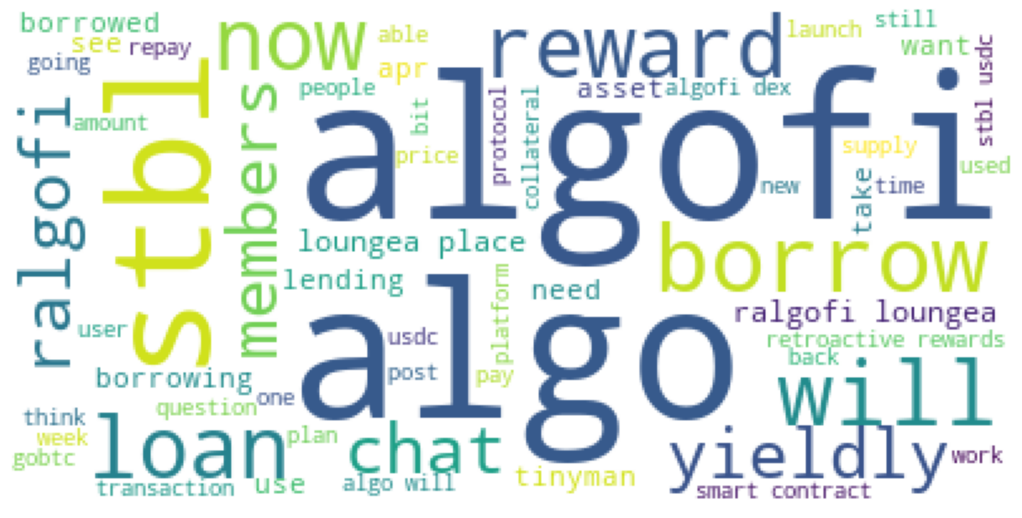

In [21]:
reddit_plot(algofi_data, "post_body").get_wordcloud()

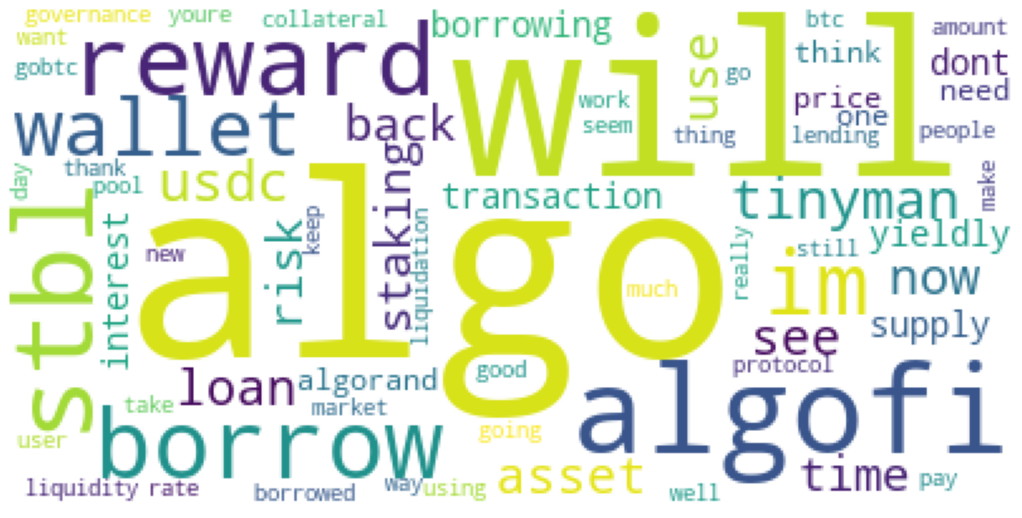

In [22]:
reddit_plot(algofi_data, "comment_body").get_wordcloud()

# **Sentiment Analysis**

We make sense out of different social media post by classifying texts or parts of texts into a pre-defined sentiment - Postive-Negative-Neutral. Here, we used VADER, a rule-based feeling analysis AI model that is explicitly sensitive to suppositions communicated in media. With Algofi data, most sentiments appear to be positive, some are neutral, with the least being negative. 

In [23]:
reddit_plot(algofi_data, "post_sentiment").get_sentiment("post_sentiment", "comment_sentiment")

# **Algogems**

Using Algogems Asset on Reddit as a Case Study.

## **Trend of Upvotes Per Day**

 This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards Algogems as an asset on Reddit. The trend is shown per day of the month. Hover on the interactive plots below to observe the trend.

In [24]:
reddit_plot(algogems_data, "post_upvotes").check_upvotes(days= True)

In [25]:
reddit_plot(algogems_data, "comment_upvotes").check_upvotes(days= True)

# **Trend of Upvotes Per Hour**

This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards Algogems as an asset on Reddit. The trend is shown per hour of the day. Hover on the interactive plots below to observe the trend.

In [26]:
reddit_plot(algogems_data, "post_upvotes").check_upvotes(hour= True)

In [27]:
reddit_plot(algogems_data, "comment_upvotes").check_upvotes(hour= True)

# **Trend of Upvotes per Weekday**

 This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards Algogems as an asset on Reddit. The trend is shown per weekday. It shows that most posts and comments are dropped on Fridays. Hover on the interactive plots below to observe the trend.

In [28]:
reddit_plot(algogems_data, "post_upvotes").check_upvotes()

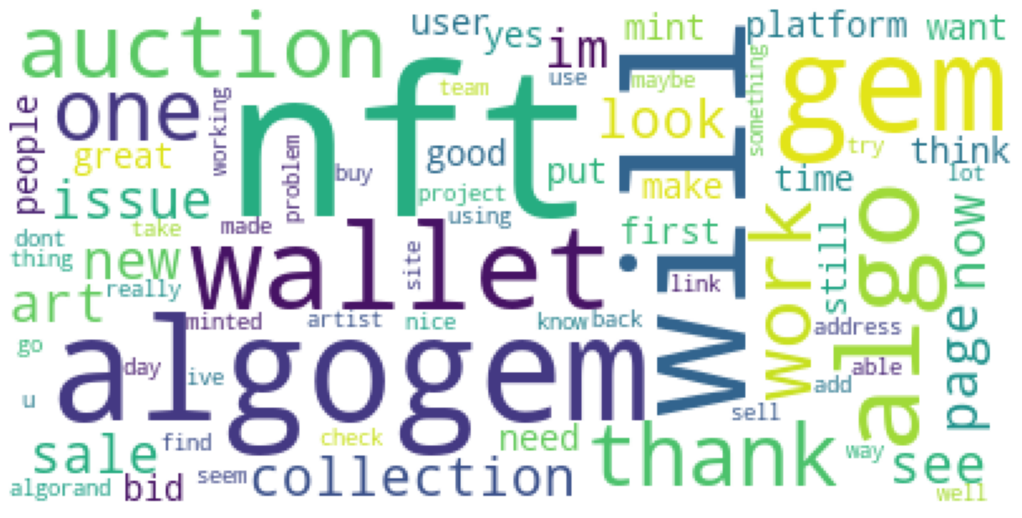

In [29]:
reddit_plot(algogems_data, "comment_body").get_wordcloud()

# **Sentiment Analysis**

With Algogems data, most sentiments appear to be positive, some are neutral, with the least being negative. 

In [30]:
reddit_plot(algogems_data, "post_sentiment").get_sentiment("post_sentiment", "comment_sentiment")

# **ChoiceCoin**

Using ChoiceCoin Asset on Reddit as a Case Study

## **Trend of Upvotes Per Day**

 This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards ChoiceCoin as an asset on Reddit. The trend is shown per day of the month. Hover on the interactive plots below to observe the trend.

In [31]:
reddit_plot(choice_data, "post_upvotes").check_upvotes(days= True)

In [32]:
reddit_plot(choice_data, "comment_upvotes").check_upvotes(days= True)

## **Trend of Upvotes Per Hour**

 This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards ChoiceCoin as an asset on Reddit. The trend is shown per hour of the day. Hover on the interactive plots below to observe the trend.

In [33]:
reddit_plot(choice_data, "post_upvotes").check_upvotes(hour= True)

In [34]:
reddit_plot(choice_data, "comment_upvotes").check_upvotes(hour= True)

# **Trend of Upvotes per Weekday**

 This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards ChoiceCoin as an asset on Reddit. The trend is shown per weekday. It shows that most posts and comments are dropped on Fridays. Hover on the interactive plots below to observe the trend.

In [35]:
reddit_plot(choice_data, "post_upvotes").check_upvotes()

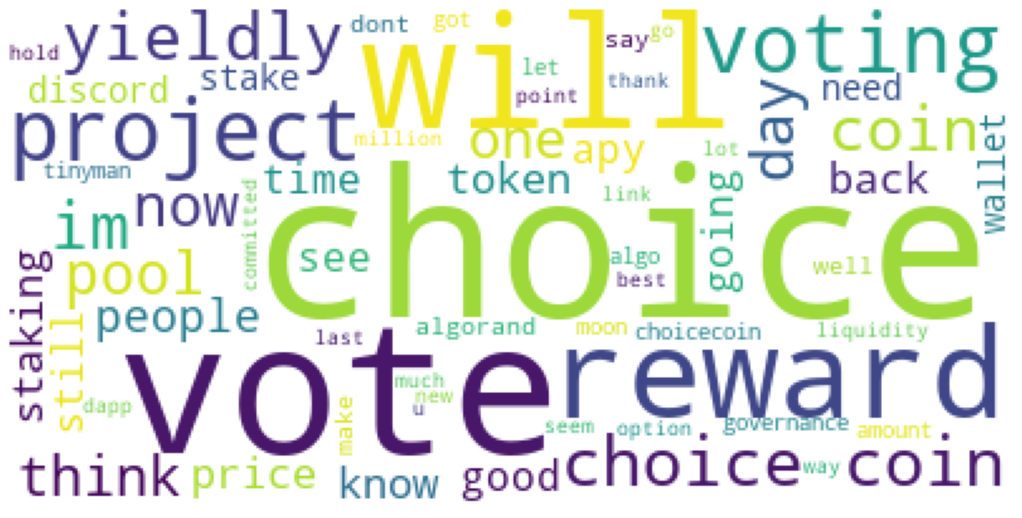

In [36]:
reddit_plot(choice_data, "comment_body").get_wordcloud()

# **Sentiment Analysis**

With ChoiceCoin data, most sentiments appear to be positive, some are neutral, with the least being negative. 

In [37]:
reddit_plot(choice_data, "post_sentiment").get_sentiment("post_sentiment", "comment_sentiment")

# **Algomint**

Using Algomint Asset on Reddit as a Case Study

## **Trend of Upvotes Per Day**

 This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards Algomint as an asset on Reddit. The trend is shown per day of the month. Hover on the interactive plots below to observe the trend.

In [38]:
reddit_plot(algomint_data, "post_upvotes").check_upvotes(days= True)

In [39]:
reddit_plot(algomint_data, "comment_upvotes").check_upvotes(days= True)

## **Trend of Upvotes Per Hour**

 This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards Algomint as an asset on Reddit. The trend is shown per hour of the day. Hover on the interactive plots below to observe the trend.

In [40]:
reddit_plot(algomint_data, "post_upvotes").check_upvotes(hour= True)

In [41]:
reddit_plot(algomint_data, "comment_upvotes").check_upvotes(hour= True)

# **Trend of Upvotes per Weekday**

 This individual plot intends to convey a pattern and show radical increase and decrease in the number of post and comment upvotes as regards Algomint as an asset on Reddit. The trend is shown per weekday. It shows that the most traffic on posts and comments are seen on Mondays. Hover on the interactive plots below to observe the trend.

In [42]:
reddit_plot(algomint_data, "post_upvotes").check_upvotes()

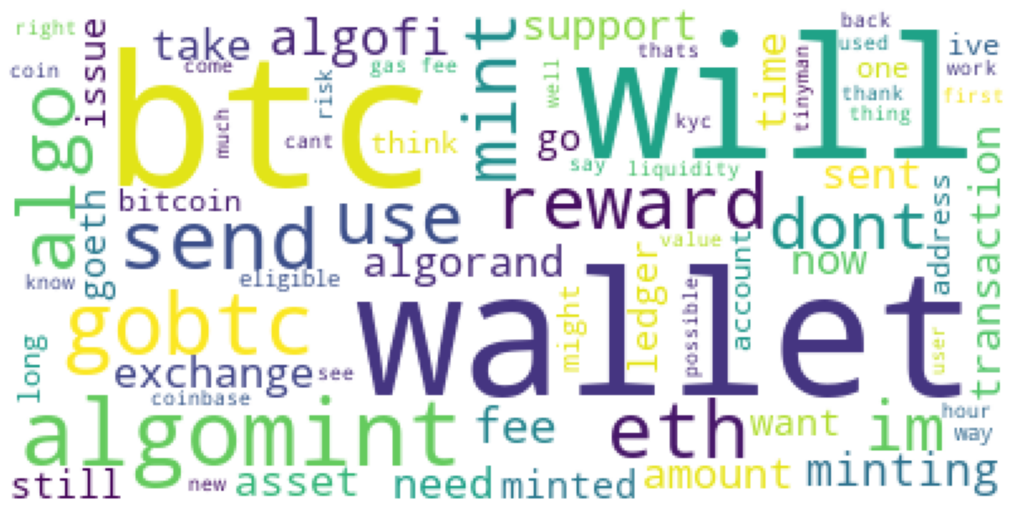

In [43]:
reddit_plot(algomint_data, "comment_body").get_wordcloud()

# **Sentiment Analysis**

With Algomint data, most sentiments appear to be positive, some are neutral, with the least being negative. 

In [44]:
reddit_plot(algomint_data, "post_sentiment").get_sentiment("post_sentiment", "comment_sentiment")